In [1]:
# 10-08-2020: new 3D model extended from P2Dwe

# gernal idea for adapting to 3D:
# make split node pairs (way to examine all split nodes?)

# 13-10-2020: need to modify defmod the code with hydrostaic pressure gradient reading 
# 14-10-2020: make the new P sync boundary condtion

# 11-08-2021: make change for one fault multiple faults (search "input" to locate the parameters you want to change)

# 23-08-2021: to do: stable initial loading; boundary reflection

In [2]:
import numpy as np
import h5py
import os, sys
import meshio
# sys.path.append('/home/jingmingruan/ownCloud/dataprocessing')
sys.path.append('/vardim/home/ruanjm/DeepNL/dataprocessing')
# sys.path.append('/home/jingmingruan/TUD/DeepNL/cloud/dataprocessing')
from inpfunc import *

In [3]:
# convert msh to h5
# %run /home/jingmingruan/ownCloud/dataprocessing/Gmsh_h5_3D.py -m Zeerijp -e2 "triangle" -e3 "tetra" -mo 0 -km 0
# %run /home/jingmingruan/TUD/DeepNL/cloud/dataprocessing/Gmsh_h5_3D.py -m Zeerijp -e2 "triangle" -e3 "tetra" -mo 1 -km 0

In [4]:
h5_m1 = h5py.File('Zeerijp_anhydrite_20m.h5', 'r')
name_out = "Zeerijp_anhydrite.inp"
save_checkpoint = 0
load_checkpoint = 1
load_init_BC = 0
dbl_trac = 0
init_sigmay = 1
load_vtk = 0

In [5]:
phy_flt = []
phy_fb = []
phy_bound = [31,33,29,32,34,30] # -x -y- z +x +y +z

In [6]:
# Model header
dsp_hyb = 1
poro = 1
dim = 3
ndy = 30
grad_BC = 1

t = 3600*24*ndy; dt = 3600*24*1; nviz = 1 
if init_sigmay or load_vtk: t = 3600*24*1
# 1e-6 0.3m lc
dt_dyn=1e-3; t_dyn = 0.5; t_lim = 1; dsp=1; Xflt=1; rsf=0; v_bg=1E-12
bod_frc=1; hyb=1; nviz_dyn=int(1e-2/dt_dyn); nviz_wave=int(1e-2/dt_dyn); nviz_slip=int(1e-2/dt_dyn)
alpha= 0.; beta = 0.00125; rfrac = 0

init=0; init_BC=0; reform_BC=0
if load_init_BC: init_BC=1

if poro:
    line1 = ["fault-p tet 36"]
else:
    line1 = ["fault tet 36"]
line3 = np.array([t, dt, nviz, dsp]).reshape(1,4)
line4 = np.array([t_dyn, dt_dyn, nviz_dyn, t_lim, dsp_hyb, Xflt, bod_frc,hyb,rsf,init,init_BC,reform_BC]).reshape(1,12)
if rsf==0:
    line5 = np.array([nviz_wave,nviz_slip]).reshape(1,2)
else:
    line5 = np.array([nviz_wave,nviz_slip,v_bg]).reshape(1,3)
line6 = np.array([alpha, beta]).reshape(1,2)

In [7]:
# inputs
print ('Extracting FE mesh...')
coord = (h5_m1['Domain/Vertices'][:,:3]) # input(km)
nnd_ori = len(coord)
rho=np.array([2150.,2840.,2430.,2650.])
E=np.array([23.7e9,45.3e9,15.0e9,18.4e9])
nu=np.array([0.29,0.26,0.20,0.27])
# E=rho*vs**2*(3*vp**2-4*vs**2)/(vp**2-vs**2)
# nu=(vp**2-2*vs**2)/2/(vp**2-vs**2)

E_dyn= E * 2 # Rick 2018 assumed dynamic E_dyn = 2 * E
nu_dyn=nu
K=np.array([9E-11,9E-11,9E-11,9E-11])/1.5E-4
vs = np.sqrt(E_dyn/2./rho/(1.+nu_dyn))
vp = np.sqrt(E_dyn*(1.-nu_dyn)/rho/(1.+nu_dyn)/(1.-2*nu_dyn))

#solid viscosity; power law
visc = 1E25 # solid viscosity [Pa·s] (visc optional)
r = 1. # viscoelastic power law parameter, (visc optional)
B=1. #Biot coef
phi=.20 #porosity
phir=.20 #(NAM,2016)
cf= 2.2e9 #fluid bulk modulus(water)
cfr=2.2e9 # 1.4e5 (Phung K.T. Nguyen1and Myung Jin Nam1,2,*) 180Mpa

mat = [[E[0], nu[0], visc, r, rho[0], K[0], B, phi, cf, 0,E_dyn[0],nu_dyn[0]],
       [E[1], nu[1], visc, r, rho[1], K[1], B, phir,cfr,0,E_dyn[1],nu_dyn[1]],
       [E[2], nu[2], visc, r, rho[2], K[2], B, phi, cf, 0,E_dyn[2],nu_dyn[2]]]
mat_typ = np.empty(shape = (0,1), dtype=np.uint32)

tet_node = (h5_m1['Domain/Cells'][:,1:])
print ('%d nodes, %d elements' %(nnd_ori, len(tet_node)))

HF=1.0
hhf = [[HF, HF, HF, HF, HF, HF, HF, HF, HF],
       [HF, HF, HF, HF, HF, HF, HF, HF, HF],
       [HF, HF, HF, HF, HF, HF, HF, HF, HF]]

#convert gmsh numbering to exodusII numbering
work = tet_node
work2 = work.T[[0,3,1,2]]
tet_node = work2.T

Extracting FE mesh...
57249 nodes, 327869 elements


In [8]:
print (coord[:,0].min(),coord[:,0].max())
print (coord[:,1].min(),coord[:,1].max())
print (coord[:,2].min(),coord[:,2].max())

244.1309745962156 246.8630254037845
596.0549745962155 598.7870254037844
-3.350000000000003 -2.35


In [9]:
lbd=rho*(vp**2-2*vs**2); mu=rho*vs**2
if rsf==1:
    L=np.mean(L); a=np.mean(a); b=np.mean(b)
    sigma_e=max(map(abs,trac_val))
    hstar=min(2*mu*L/(b-a)/np.pi/sigma_e)
    print ("Critical RSF distance h*=%0.3f m" %hstar)
Lc=min(dt_dyn*np.sqrt(E_dyn/rho))
print (("Critical element length h=%0.3f m" %Lc))

Critical element length h=3.514 m


In [10]:
# h5_m2.visit(printname)
# Print info based on header input
if Xflt>1:
    print ("Expecting multiple faults and intersection(s)")

In [11]:
# Observation locations
ogrid=np.array([[ 0.5, 1, -1.4],
                [ 0.5, 2, -1.4],
                [ 0.5, 3, -1.4],
                [ 2, 1, -1.4],
                [ 2, 2, -1.4],
                [ 2, 3, -1.4],
                [ 3.5, 1, -1.4],
                [ 3.5, 2, -1.4],
                [ 3.5, 3, -1.4]])

In [12]:
mat_typ = np.zeros((len(tet_node)),dtype=np.uint32).reshape(-1)
cell_mat = []
# ! input materal dict
options = {}


for i in range(1,8):
    options[i] = 1
for i in range(8,15):
    options[i] = 2
for i in range(15,22):
    options[i] = 3
for i in range(22,29):
    options[i] = 4
    
for i in range(1,29): # debug: check the group number for the cell ! input
    print (i)
    cell_mat.append(h5_m1['Regions/group%d/Cell Ids' %(i)][:])

for i in range(len(cell_mat)): # bug: manually check the layers with multiple physical groups
    for j in range(len(cell_mat[i])):
        mat_typ[cell_mat[i][j]-1] = options[i+1]



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [13]:
# Duplicate the fault nodes (off-boundary) (CHANGE!) 
# ! input
flt_tri = np.empty(shape=[0, 3], dtype=np.uint32) # should be flt_lin but made same as 3D
flt_tri_bdr = np.empty(shape=[0, 2], dtype=np.uint32)
flt_tri_index = np.empty(shape=(0), dtype=np.uint32) # should be flt_lin but made same as 3D
flt_tri_seg = []
for i in range(35,49): # input first main fault then aux fault (or just one fault)
    felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
    flt_tri_seg.append(felem)
    flt_tri = np.vstack((flt_tri, felem))
    flt_tri_index = np.hstack((flt_tri_index,i*np.ones(len(felem),dtype=np.uint32)))
# flt_node = np.unique(flt_tri)

for i in [49]: # input fault boundary node & intersection
    if i == 10: # one-node intersection
        felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][1:])
    else:
        felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
    flt_tri_bdr = np.vstack((flt_tri_bdr, felem))
flt_xbdr_node = np.unique(flt_tri_bdr)

ft_pos_nodes_seg = []
ft_pos_nodes = np.empty(shape=[0, 3], dtype=np.uint32)
for i in range(35,49): #input first main fault then aux fault 
    felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
    flt_node = np.unique(felem)
    flt_node = flt_node[np.in1d(flt_node,flt_xbdr_node,invert=True)]
    ft_pos_nodes_seg.append(np.unique(flt_node))
    
    ft_pos_nodes = np.vstack((ft_pos_nodes, felem))

# only main fault slip
flt_tri_main = np.empty(shape=[0, 3], dtype=np.uint32)
for i in range(35,49):
    felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
    flt_tri_main = np.vstack((flt_tri_main, felem))
# aux fault
if Xflt>1:
    flt_tri_aux = np.empty(shape=[0, 3], dtype=np.uint32)
    for i in [13]: # input aux
        felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
        flt_tri_aux = np.vstack((flt_tri_aux, felem))
    
flt_node = np.unique(ft_pos_nodes)
ft_pos_nodes = flt_node[np.in1d(flt_node,flt_xbdr_node,invert=True)]

In [14]:
# get rid of competley boundary flt_tri
mask = np.in1d(flt_tri, flt_xbdr_node)
mask_rsh = mask.reshape((-1,3))
work_sum = np.sum(mask_rsh,axis=1)
flt_tri = flt_tri[np.where(work_sum<3)]

In [15]:
# saving for tri plot
mask = np.in1d(flt_tri, flt_xbdr_node)
mask_rsh = mask.reshape((-1,3))
work_sum = np.sum(mask_rsh,axis=1)
flt_tri_save = flt_tri[np.where(work_sum==0)]
np.save("flt_tri_nob",flt_tri_save)

### Searching for nodes and elements to perform BC or fault constraint (Computationally heavy) 
### Skip to load checkpoint if needed!!!

In [ ]:
# testing auto detecting negative side
# Debug: auto Replace the negative side 
# ! input postive direction

tet_node, coord, ft_neg_nodes = Crack3D(tet_node,coord,flt_tri,ft_pos_nodes,"tet") 

In [ ]:
# find out the element contain the fault elements
flt_tet = SearchFltele3D(tet_node,flt_tri,coord,"tet")

In [ ]:
# auto replace intersecting nodes

if Xflt>1:    
    ft_xinit_nodes = np.unique(h5_m1['Regions/group15/Vertex Ids'][1:])
    ft_xinit_nodes_bdr = np.unique(h5_m1['Regions/group16/Vertex Ids'][1:])
    ft_xinit_nodes = ft_xinit_nodes[np.in1d(ft_xinit_nodes,ft_xinit_nodes_bdr,invert=True)]

    flt_tri_all = np.empty(shape=[0, 3], dtype=np.uint32) # should be flt_lin but made same as 3D
    flt_tri_index_all = np.empty(shape=(0), dtype=np.uint32) # should be flt_lin but made same as 3D
    flt_tri_seg_all = []

    for i in [11,12,13,14]: # input first main fault then aux fault (include all branches!!)
        felem = (h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
        flt_tri_seg_all.append(felem)
        flt_tri_all = np.vstack((flt_tri_all, felem))
        flt_tri_index_all = np.hstack((flt_tri_index_all,i*np.ones(len(felem),dtype=np.uint32)))

    tet_node,coord,ft_x_nodes = Xflt3D(tet_node,coord,flt_tri_all,flt_tri_seg_all,ft_xinit_nodes)
else:
    ft_x_nodes = np.empty(shape=(0), dtype=np.uint32)
    
nnd = len(coord)
nxfnd = len(ft_x_nodes) * 2
nfnd = len(ft_pos_nodes) + nxfnd

In [ ]:
rotate_angle = 30
if rotate_angle>0:
    print ("Rotating axis with angle %0.3f degree..." %rotate_angle)
    new_yaxis = np.array([np.sin(rotate_angle*np.pi/180), np.cos(rotate_angle*np.pi/180), 0])
    new_zaxis = np.array([0, 0, 1])
    new_xaxis = np.cross(new_yaxis, new_zaxis)
    new_xaxis = new_xaxis / np.sqrt(np.sum(new_xaxis**2))
    new_yaxis = new_yaxis / np.sqrt(np.sum(new_yaxis**2))
    new_zaxis = new_zaxis / np.sqrt(np.sum(new_zaxis**2))
    new_axes  = np.array([new_xaxis, new_yaxis, new_zaxis])
    old_axes = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=float).reshape(3, -1)
    rotation_matrix = np.inner(new_axes,old_axes)
    coord_rt = np.zeros_like(coord)
    for i in range(coord.shape[0]):
        coord_rt[i,:] = np.inner(coord[i,:],rotation_matrix)
    coord = np.copy(coord_rt)

how to split nodes? 

1a. find out the split nodes on the fault plane. (optional)
1b. find out the boundary nodes that is not splitted.
2. find the elements that contain the split nodes in the negative side \\
    1) replace the crack version ()
    2) replace in the original version (X)


In [ ]:
# forming fault constaint coeffecient (Q: should this be on the positive side?)
# 3D fault constraint coefficient

vec_fs,vec_fn,vec_fd = Vecfsn3D(coord,flt_tri,flt_tet,flt_tri_index,ft_x_nodes,ft_pos_nodes,"tet")

# crosslink constraint for xflt main fault
if Xflt>1:
    vec_fs,vec_fn,vec_fd = Vecfsn3D_X(coord,flt_tet,flt_tri,flt_tri_main,ft_x_nodes,\
                               ft_pos_nodes,vec_fs,vec_fn,vec_fd)

    vecx_fs, vecx_fn, vecx_fd = VecXfsn3D_X(coord,flt_tri_aux,ft_x_nodes)

    vecx_fs /= (np.ones((3,1))*np.linalg.norm(vecx_fs, axis=1)).T # normalized
    vecx_fd /= (np.ones((3,1))*np.linalg.norm(vecx_fd, axis=1)).T
    vecx_fn /= (np.ones((3,1))*np.linalg.norm(vecx_fn, axis=1)).T

vec_fs /= (np.ones((3,1))*np.linalg.norm(vec_fs, axis=1)).T # normalized
vec_fd /= (np.ones((3,1))*np.linalg.norm(vec_fd, axis=1)).T
vec_fn /= (np.ones((3,1))*np.linalg.norm(vec_fn, axis=1)).T

# vec_fs = np.round(vec_fs,6)
# vec_fd = np.round(vec_fd,6)
# vec_fn = np.round(vec_fn,6)

In [ ]:
bnd_el = []
# ! input (boundary elements) in the order of abs & tract  
for i in phy_bound:  # in the order of -x -y- z +x +y +z
    bnd_el.append(h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])

cell_map_bc = BCeleside3D(tet_node,bnd_el,"tet")

### Computationally heavy part Finished! 

In [16]:
# saving check point for parameter fixing
# tet_node, coord, ft_neg_nodes, flt_tet, ft_x_nodes
# vec_fs, vec_fd, vec_fn
# cell_map_bc
if save_checkpoint:
    print ("Saving checkpoint data...")
    fout_h5 = 'Zeerijp3D_checkpoint.h5'
    try:
        os.remove(fout_h5)
    except OSError:
        pass

    f = h5py.File(fout_h5, "w")
    grp = f.create_group('All')
    grp.create_dataset('tet_node', data=tet_node, dtype=np.int32)
    grp.create_dataset('coord', data=coord, dtype=np.float64)
    grp.create_dataset('ft_neg_nodes', data=ft_neg_nodes, dtype=np.int32)
    grp.create_dataset('ft_x_nodes', data=ft_x_nodes, dtype=np.int32)
    grp.create_dataset('vec_fs', data=vec_fs, dtype=np.float64)
    grp.create_dataset('vec_fd', data=vec_fd, dtype=np.float64)
    grp.create_dataset('vec_fn', data=vec_fn, dtype=np.float64)
    for i in range(len(cell_map_bc)):
        grp.create_dataset("BC_group%d" % ((i)), data=cell_map_bc[i], dtype=np.int32)
    f.close()
    print (fout_h5 + '...checkpoint created.')
    
    
if load_checkpoint:
    print ("Loading check point data...")
    f_checkpoint = h5py.File('Zeerijp3D_checkpoint.h5', 'r')
    tet_node = f_checkpoint['All/tet_node'][:]
    coord = f_checkpoint['All/coord'][:]
    ft_neg_nodes = f_checkpoint['All/ft_neg_nodes'][:]
    ft_x_nodes = f_checkpoint['All/ft_x_nodes'][:]
    vec_fs = f_checkpoint['All/vec_fs'][:]
    vec_fd = f_checkpoint['All/vec_fd'][:]
    vec_fn = f_checkpoint['All/vec_fn'][:]
    
    bnd_el = []
    # ! input (boundary elements) in the order of abs & tract  
    for i in phy_bound: 
        bnd_el.append(h5_m1['Regions/group%d/Vertex Ids' %(i)][:,1:])
    cell_map_bc = []
    for i in range(6):
        cell_map_bc.append(f_checkpoint['All/BC_group%d' % ((i))][:])
        
    nnd = len(coord)
    nxfnd = len(ft_x_nodes) * 2
    nfnd = len(ft_pos_nodes) + nxfnd
    

Loading check point data...


In [17]:
# input for fault parameters !!
if poro: perm = np.zeros((nfnd,1)) # set it to zero if impose offset pressure profile

st_init = np.zeros((nfnd,3))
frc=np.ones((nfnd,1),dtype=np.uint32)
fc=.4*np.ones((nfnd,1),dtype=np.float64)
fcd=.3*np.ones((nfnd,1),dtype=np.float64)
dc=0.2*np.ones((nfnd,1),dtype=np.float64)
coh=np.zeros((nfnd,1))
dcoh=np.ones((nfnd,1))
biot=1. * np.ones((nfnd,1))

In [18]:
# change the array order
abs_bc1  = cell_map_bc[0] # -x
abs_bc2  = cell_map_bc[1] # -y
abs_bc3  = cell_map_bc[2] # bot
trac_el1 = cell_map_bc[3] # +x
trac_el2 = cell_map_bc[4] # +y
trac_el3 = cell_map_bc[5] # top

In [19]:
from plot_3D import *
if load_init_BC:
    ini_stress = plot3D("./Zeerijp_fe.h5",dyn=0)

In [20]:
# setting initial stress based on idcase
# Make the fault permeable at certain segment; add initial stress 
# permeable at certain depth as well the friction law
x_min = min(coord[:,1]); x_max = max(coord[:,1])
y_min = min(coord[:,1]); y_max = max(coord[:,1])
z_min = min(coord[:,2]); z_max = max(coord[:,2])

rho_g = 200
rho_f = 1150
P_init = 35e6
nu = 0.15
g = 9.80665
top_tra = -2350 * 2020 * g/1e6
rho = np.array(mat)[:,4]
dep = np.array([-2.35, -2.81,-2.86,-3.14]) # edit!
grav_mat = np.array(np.diff(dep)*rho[:])
grav_mat = np.hstack((0,grav_mat))

Kx = [0.748, 0.748, 0.748] # 0.748 
Ky = [0.795, 0.795, 0.795] # 0.795

j = 0

# overwrite the initial stress with given stress
if init_BC:       
    for node_pos, i in zip(ft_pos_nodes, range(len(ft_pos_nodes))):
        y = coord[node_pos - 1,2] # y here is the depth
        # to determin which material it is in
        if   y >= dep[1]:
            mat_el = 1
            pressure = -(y*1e3) * g * rho_f 
        elif y >= dep[2] and y < dep[1]:
            mat_el = 2
            pressure = -(y*1e3) * g * rho_f 
        elif y >= dep[3] and y < dep[2]:
            mat_el = 3
            pressure = (-1*y+dep[2]) * 1e3 * g *rho_g + P_init
        else:
            mat_el = 4
            pressure = (-1*y+dep[2]) * 1e3 * g * rho_f + P_init
        # separate stress field from gravity and traction
        sigma_y = -1*(top_tra + g*1E3*((y-dep[mat_el-1])*rho[mat_el-1]+np.sum(grav_mat[:mat_el]))) - pressure
        sigma_x = -Kx[mat_el-1]*(top_tra + g*1E3*((y-dep[mat_el-1])*rho[mat_el-1]+np.sum(grav_mat[:mat_el]))) - pressure

        stn = -1*(sigma_y+sigma_x)/2 - (sigma_y-sigma_x)/2*np.cos(np.pi*40/180)
        std = (sigma_y-sigma_x)/2*np.sin(np.pi*40/180)
        sts = 0
        if load_init_BC:
            sts = ini_stress.dat_trac_sta[:,0,0][i]
            std = ini_stress.dat_trac_sta[:,1,0][i]
            stn = ini_stress.dat_trac_sta[:,2,0][i] # effective normal stress
            pressure = ini_stress.dat_trac_sta[:,3,0][i]
        st_init[i,:]=[sts,std,(stn-pressure)]
        

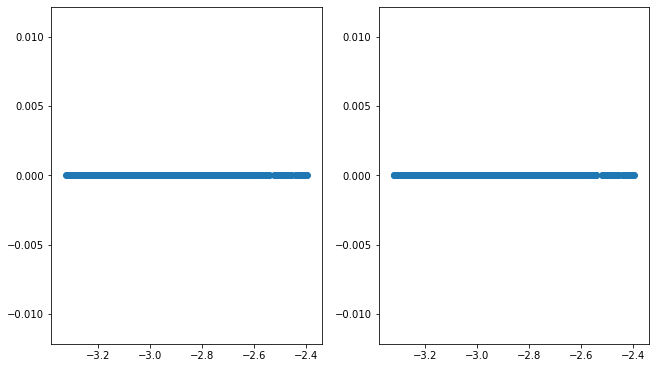

In [21]:
# plotting initial stress
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
tcoord = coord[ft_pos_nodes-1,:]
zcnt = tcoord[:,2]

fig = plt.figure(figsize=(9,5),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=1, left=0.05, right=0.98, wspace=0.05, figure=fig)
f2_ax1 = fig.add_subplot(spec2[0])
f2_ax1.scatter(zcnt,st_init[:,1])

f2_ax2 = fig.add_subplot(spec2[1])
f2_ax2.scatter(zcnt,st_init[:,2])


In [22]:
if poro:
    bc_typ = np.ones((nnd,4), dtype=np.int8)
else:
    bc_typ = np.ones((nnd,3), dtype=np.int8)

# input
# fixed nodes & sync pressure on the boudary and reservoir
bcx_nodes = bnd_el[0]
bcy_nodes = bnd_el[1]
bcz_nodes = bnd_el[2]


for node in bcx_nodes.reshape(-1):
    bc_typ[node - 1, 0] = 0
for node in bcy_nodes.reshape(-1):
    bc_typ[node - 1, 1] = 0
for node in bcz_nodes.reshape(-1):
    bc_typ[node - 1, 2] = 0

if dbl_trac or load_vtk:
    for node in bcx_nodes.reshape(-1):
        bc_typ[node - 1, 0] = 1
    for node in bcy_nodes.reshape(-1):
        bc_typ[node - 1, 1] = 1
    
if init_BC or init_sigmay:
    bcx_nodes = bnd_el[3]
    bcy_nodes = bnd_el[4]
    # bcz_nodes = bnd_el[5]

    for node in bcx_nodes.reshape(-1):
        bc_typ[node - 1, 0] = 0
    for node in bcy_nodes.reshape(-1):
        bc_typ[node - 1, 1] = 0
    # for node in bcz_nodes.reshape(-1):
    #     bc_typ[node - 1, 2] = 0
        
# Pressure sync (debug)
if poro:
    bc_typ[:, 3] = 2


In [23]:
# apply extrac boundary condition when using traction-pair boundary condition (only on the top)
if dbl_trac or load_vtk:
    i = 0
    for side in [1,4]:  # - + y
        bcy_nodes = bnd_el[side]
        bcoord = coord[bcy_nodes.reshape(-1)-1,:]
        bnode = [[(coord[:,0].min()+coord[:,0].max())/2, coord[:,1].min(), coord[:,2].max()]
                 ,[(coord[:,0].min()+coord[:,0].max())/2, coord[:,1].max(), coord[:,2].max()]]
        dis = np.linalg.norm(bcoord - np.dot(np.ones((len(bcoord), 1)),\
                np.array(bnode[i]).reshape(1,3)), axis=1)
        row = np.argsort(dis)[0]
        bnode_nr = bcy_nodes.reshape(-1)[row]
        print (bnode_nr)
        print (coord[bnode_nr-1])
        bc_typ[bnode_nr-1,0] = 0 
        i += 1
    i = 0    
    for side in [0,3]:  # - + x
        bcy_nodes = bnd_el[side]
        bcoord = coord[bcy_nodes.reshape(-1)-1,:]
        bnode = [[(coord[:,0].min(), coord[:,1].min()+coord[:,1].max())/2, coord[:,2].max()]
                 ,[(coord[:,0].max(), coord[:,1].min()+coord[:,1].max())/2, coord[:,2].max()]]
        dis = np.linalg.norm(bcoord - np.dot(np.ones((len(bcoord), 1)),\
                np.array(bnode[i]).reshape(1,3)), axis=1)
        row = np.argsort(dis)[0]
        bnode_nr = bcy_nodes.reshape(-1)[row]
        print (bnode_nr)
        print (coord[bnode_nr-1])
        bc_typ[bnode_nr-1,1] = 0
        i += 1

    bcc_typ = np.copy(bc_typ)

In [24]:
# (test) changing boundary conditions during run
bcc_typ = np.copy(bc_typ)
if reform_BC:
    bcx_nodes = bnd_el[3]
    bcy_nodes = bnd_el[4]
    # bcz_nodes = bnd_el[5]

    for node in bcx_nodes.reshape(-1):
        bcc_typ[node - 1, 0] = 0
    for node in bcy_nodes.reshape(-1):
        bcc_typ[node - 1, 1] = 0
    # for node in bcz_nodes.reshape(-1):
    #     bcc_typ[node - 1, 2] = 0

In [25]:
if poro:
    trac_bc1 = np.zeros(shape=[len(trac_el1), 6])
    trac_bc2 = np.zeros(shape=[len(trac_el2), 6])
    trac_bc3 = np.zeros(shape=[len(trac_el3), 6])
    if dbl_trac:
        trac_bc4 = np.zeros(shape=[len(abs_bc1), 6]) # -x 
        trac_bc5 = np.zeros(shape=[len(abs_bc2), 6]) # -y
else:
    trac_bc1 = np.zeros(shape=[len(trac_el1), 5])
    trac_bc2 = np.zeros(shape=[len(trac_el2), 5])
    trac_bc3 = np.zeros(shape=[len(trac_el3), 5])

#--------------gradient traction BC------------ 
if grad_BC:
    
    dep = -0.0; g = 9.80665; p0 = -23.6e6 #top depth, gravity constant, top pressuure
    rho = np.array(mat)[:,4]
    
    p0 = (-2.35)*rho[0]*g*1000

    # density 
    rhox = np.array([rho[0],rho[1],rho[2]])
    rhoy = np.array([rho[0],rho[1],rho[2]])
    # layer boundaries
    formbdx = np.sort(np.array([-1.2,-2.85,-3.05,-5]))
    formbdy = np.sort(np.array([-1.2,-2.85,-3.05,-5]))
    # Horizontal vertical stress ratio
    Kx = [0.748, 0.748, 0.748, 0.748] # 0.748 
    Ky = [0.795, 0.795, 0.795, 0.795] # 0.795

    # uniform vertical traction on the top
    # trac_bc3[:,2] = -p0+dep*1E3*rho[0]*g 
    trac_bc3[:,2] = p0
    # gradient traction on the sides
    for el,i in zip(trac_el1,range(len(trac_bc1))):
        el_node = tet_node[el[0]-1,:] 
        tcoord = coord[el_node-1,:]
        zcnt = np.mean(tcoord,0)[2]
        sigma_x = Kx[0]*(p0-dep*1E3*rhox[0]*g) # east to west
        for j in range(len(formbdx)-1): # integrate in depth 
            sigma_x += -1*g*1E3*Kx[j]*rhox[j]*((zcnt<=formbdx[j])*(formbdx[j+1]-formbdx[j])+(zcnt>formbdx[j] and zcnt<=formbdx[j+1])*(formbdx[j+1]-zcnt))
        trac_bc1[i,0] = sigma_x
        #trac_bc1[i,0] = -2.8E7 #Kx[-1]*(-p0+zcnt*1E3*rho[-1]*g)
    for el,i in zip(trac_el2,range(len(trac_bc2))):
        el_node = tet_node[el[0]-1,:] 
        tcoord = coord[el_node-1,:]
        zcnt = np.mean(tcoord,0)[2]
        sigma_y = Ky[0]*(p0-dep*1E3*rhoy[0]*g) # south to north
        for j in range(len(formbdy)-1): # integrate in depth 
            sigma_y += -1*g*1E3*Ky[j]*rhoy[j]*((zcnt<=formbdy[j])*(formbdy[j+1]-formbdy[j])+(zcnt>formbdy[j] and zcnt<=formbdy[j+1])*(formbdy[j+1]-zcnt))
        trac_bc2[i,1] = sigma_y
        #trac_bc2[i,1] = 2.4E7 #Ky[-1]*(p0-zcnt*1E3*rho[-1]*g)
        
    if dbl_trac and init_BC==0:
        formbdx = np.sort(np.array([-1.2,-2.80,-3.00,-5]))
        formbdy = np.sort(np.array([-1.2,-2.80,-3.00,-5]))
        for el,i in zip(abs_bc1,range(len(trac_bc4))):
            el_node = tet_node[el[0]-1,:] 
            tcoord = coord[el_node-1,:]
            zcnt = np.mean(tcoord,0)[2]
            sigma_x = Kx[0]*(p0-dep*1E3*rhox[0]*g) # south to north
            for j in range(len(formbdx)-1): # integrate in depth 
                sigma_x += -1*g*1E3*Kx[j]*rhox[j]*((zcnt<=formbdx[j])*(formbdx[j+1]-formbdx[j])+(zcnt>formbdx[j] and zcnt<=formbdx[j+1])*(formbdx[j+1]-zcnt))
            trac_bc4[i,0] = -1*sigma_x
        for el,i in zip(abs_bc2,range(len(trac_bc5))):
            el_node = tet_node[el[0]-1,:] 
            tcoord = coord[el_node-1,:]
            zcnt = np.mean(tcoord,0)[2]
            sigma_y = Ky[0]*(p0-dep*1E3*rhoy[0]*g) # south to north
            for j in range(len(formbdy)-1): # integrate in depth 
                sigma_y += -1*g*1E3*Ky[j]*rhoy[j]*((zcnt<=formbdy[j])*(formbdy[j+1]-formbdy[j])+(zcnt>formbdy[j] and zcnt<=formbdy[j+1])*(formbdy[j+1]-zcnt))
            trac_bc5[i,1] = -1*sigma_y

        
    if poro: # time for applying traction
        trac_bc3[:,4] = 0.; trac_bc3[:,5] = 0. 
        trac_bc1[:,4] = 0.; trac_bc1[:,5] = 0. 
    else:
        trac_bc3[:,3] = 0; trac_bc3[:,4] = 0.
        
#--------------uniform traction BC------------ 
else:
    trac_val=[-0E6, -0E6, -0E6] # xyz
    if poro:
        trac_bc1[:,0]=trac_val[0]; trac_bc1[:,4]=0.; trac_bc1[:,5]=0.
        trac_bc2[:,1]=trac_val[1]; trac_bc2[:,4]=0.; trac_bc2[:,5]=0.
        trac_bc3[:,2]=trac_val[2]; trac_bc3[:,4]=0.; trac_bc3[:,5]=0.
    else:
        trac_bc1[:,0] = trac_val[0]; trac_bc1[:,3] = 0.; trac_bc1[:,4] = 0
        trac_bc2[:,1] = trac_val[1]; trac_bc2[:,3] = 0.; trac_bc2[:,4] = 0
        trac_bc3[:,2] = trac_val[2]; trac_bc3[:,3] = 0.; trac_bc3[:,4] = 0



In [26]:
# loading vertical stress from vtk
abs_bc1  = cell_map_bc[0] # -x
abs_bc2  = cell_map_bc[1] # -y

Kx = [0.748, 0.748, 0.748, 0.748] # 0.748 
Ky = [0.795, 0.795, 0.795, 0.795] # 0.795

if load_vtk:
    mesh = meshio.read('foo_00.vtk' )
    vtk_coord = mesh.points
    ss_z = mesh.point_data['ss'][:,2]
    vtk_pressure = mesh.point_data['pressure']
    
    
    vtk_coord_bdr = vtk_coord[vtk_coord[:,0]==2] # edit!
    ss_z_bdr = ss_z[vtk_coord[:,0]==2]
    vtk_pressure_bdr = vtk_pressure[vtk_coord[:,0]==2]
    for el,i in zip(trac_el1,range(len(trac_bc1))):
        sigma_x = 0.
        el_node = tet_node[(el[0])-1,:] 
        tcoord = np.round(coord[el_node-1,:],10)
        tcoord = tcoord[tcoord[:,0]==2]
        for j in tcoord:
            dis = np.linalg.norm(vtk_coord_bdr - np.dot(np.ones((len(vtk_coord_bdr), 1)), \
                    np.array(j).reshape(1,3)), axis=1)
            row = np.argsort(dis)[0]
            if dis[row]> 1e-3: print (j,vtk_coord_bdr[row])
            sigma_x += ss_z_bdr[row]- vtk_pressure_bdr[row]
        trac_bc1[i,0] = Kx[0]*sigma_x/len(tcoord) # 
    
    vtk_coord_bdr = vtk_coord[vtk_coord[:,1]==2]
    ss_z_bdr = ss_z[vtk_coord[:,1]==2]
    vtk_pressure_bdr = vtk_pressure[vtk_coord[:,1]==2]
    for el,i in zip(trac_el2,range(len(trac_bc2))):
        sigma_y = 0.
        el_node = tet_node[(el[0])-1,:] 
        tcoord = np.round(coord[el_node-1,:],10)
        tcoord = tcoord[tcoord[:,1]==2]
        for j in tcoord:
            dis = np.linalg.norm(vtk_coord_bdr - np.dot(np.ones((len(vtk_coord_bdr), 1)), \
                    np.array(j).reshape(1,3)), axis=1)
            row = np.argsort(dis)[0]
            if dis[row]> 1e-3: print (j,vtk_coord_bdr[row])
            sigma_y += ss_z_bdr[row]- vtk_pressure_bdr[row]
        trac_bc2[i,1] = Ky[0]*sigma_y/len(tcoord) # postive direction
    
    trac_bc4 = np.zeros(shape=[len(abs_bc1), 6]) # -x 
    trac_bc5 = np.zeros(shape=[len(abs_bc2), 6]) # -y
    
    vtk_coord_bdr = vtk_coord[vtk_coord[:,0]==0]
    ss_z_bdr = ss_z[vtk_coord[:,0]==0]
    vtk_pressure_bdr = vtk_pressure[vtk_coord[:,0]==0]
    for el,i in zip(abs_bc1,range(len(trac_bc4))):
        sigma_x = 0.
        el_node = tet_node[(el[0])-1,:] 
        tcoord = np.round(coord[el_node-1,:],10)
        tcoord = tcoord[tcoord[:,0]==0]
        for j in tcoord:
            dis = np.linalg.norm(vtk_coord_bdr - np.dot(np.ones((len(vtk_coord_bdr), 1)), \
                    np.array(j).reshape(1,3)), axis=1)
            row = np.argsort(dis)[0]
            if dis[row]> 1e-3: print (j,vtk_coord_bdr[row])
            sigma_x += ss_z_bdr[row]- vtk_pressure_bdr[row]
        trac_bc4[i,0] = -1*Kx[0]*sigma_x/len(tcoord) # postive direction
        
    vtk_coord_bdr = vtk_coord[vtk_coord[:,1]==0]
    ss_z_bdr = ss_z[vtk_coord[:,1]==0]
    vtk_pressure_bdr = vtk_pressure[vtk_coord[:,1]==0]
    for el,i in zip(abs_bc2,range(len(trac_bc5))):
        sigma_y = 0.
        el_node = tet_node[(el[0])-1,:] 
        tcoord = np.round(coord[el_node-1,:],10)
        tcoord = tcoord[tcoord[:,1]==0]
        for j in tcoord:
            dis = np.linalg.norm(vtk_coord_bdr - np.dot(np.ones((len(vtk_coord_bdr), 1)), \
                    np.array(j).reshape(1,3)), axis=1)
            row = np.argsort(dis)[0]
            if dis[row]> 1e-3: print (j,vtk_coord_bdr[row])
            sigma_y += ss_z_bdr[row]- vtk_pressure_bdr[row]
        trac_bc5[i,1] = -1*Ky[0]*sigma_y/len(tcoord) # postive direction


In [27]:
if init_BC:
    trac_bc1[:,:]=0.
    trac_bc2[:,:]=0.
    trac_bc3[:,:]=0.
    
if init_sigmay:
    trac_bc1[:,:]=0.
    trac_bc2[:,:]=0.

trac_el = np.vstack((trac_el1, trac_el2, trac_el3))
trac_bc = np.vstack((trac_bc1, trac_bc2, trac_bc3))

if dbl_trac or load_vtk:
    trac_el = np.vstack((trac_el, abs_bc1, abs_bc2))
    trac_bc = np.vstack((trac_bc, trac_bc4, trac_bc5))

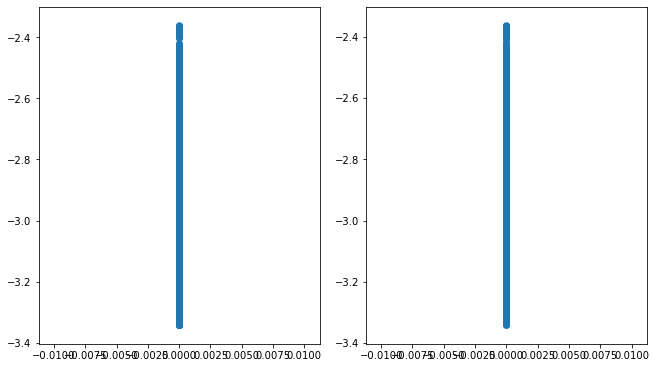

In [28]:
# plotting traction
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
el_node = tet_node[trac_el1[:,0]-1,:] 
tcoord = coord[el_node-1,:]
zcnt = np.mean(tcoord,1)[:,2]

fig = plt.figure(figsize=(9,5),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=1, left=0.05, right=0.98, wspace=0.05, figure=fig)
f2_ax1 = fig.add_subplot(spec2[0])
f2_ax1.scatter(trac_bc1[:,0],zcnt,  alpha=0.6,cmap='jet')

el_node2 = tet_node[trac_el2[:,0]-1,:] 
tcoord2 = coord[el_node2-1,:]
zcnt2 = np.mean(tcoord2,1)[:,2]

f2_ax2 = fig.add_subplot(spec2[1])
f2_ax2.scatter(trac_bc2[:,1],zcnt2,  alpha=0.6,cmap='jet')


if dbl_trac or load_vtk:
    fltt_node = tet_node[(abs_bc1[:,0].astype(int)-1),:] 
    tcoord = coord[fltt_node-1,:]
    zcnt = np.mean(tcoord,1)[:,2]
    f2_ax1.scatter(trac_bc4[:,0],zcnt,alpha=0.6,cmap='jet')
    
    fltt_node = tet_node[(abs_bc2[:,0].astype(int)-1),:] 
    tcoord = coord[fltt_node-1,:]
    zcnt = np.mean(tcoord,1)[:,2]
    f2_ax2.scatter(trac_bc5[:,1],zcnt,alpha=0.6,cmap='jet')


# f2_ax2.scatter(st_init[:,0]/st_init[:,1],coord_fltele,  alpha=0.6,cmap='jet')
# f2_ax2.set_xlim(e6, 5e6)
# f2_ax2.set_ylim( -5.0, -2.6)


In [29]:
# absorbing bc (el,side)
abs_bc1 = np.hstack((abs_bc1, np.ones((len(abs_bc1),1))))
abs_bc2 = np.hstack((abs_bc2, 2*np.ones((len(abs_bc2),1))))
abs_bc3 = np.hstack((abs_bc3, 3*np.ones((len(abs_bc3),1))))
abs_bc4 = np.hstack((trac_el1, np.ones((len(trac_el1),1))))
abs_bc5 = np.hstack((trac_el2, 2*np.ones((len(trac_el2),1))))
abs_bc6 = np.hstack((trac_el3, 3*np.ones((len(trac_el3),1))))
# abs_bc6 can be free surface 
abs_bc = np.vstack((abs_bc1, abs_bc2, abs_bc3, abs_bc4, abs_bc5, abs_bc6))

In [30]:
print (abs_bc)

[[1.37130e+05 2.00000e+00 1.00000e+00]
 [1.37294e+05 3.00000e+00 1.00000e+00]
 [1.37348e+05 2.00000e+00 1.00000e+00]
 ...
 [2.56756e+05 3.00000e+00 3.00000e+00]
 [2.60238e+05 3.00000e+00 3.00000e+00]
 [2.60083e+05 3.00000e+00 3.00000e+00]]


In [31]:
# # nodal force/source input

# # 2nodal force/flux 
# flux = 0 #-7.5E4, -5E4 ,-1E5
# src_line = [-.75, -1.5] # liner source x, z for FV sync
# if poro:
#     fnodes = [[0., -0.76, -3.00, 0, 0, 0, flux, 4*dt, (ndy-2)*dt]] 
#     fnode_bc = np.empty((0,7))
#     for fnode in fnodes:
#         dis = np.linalg.norm(coord - np.dot(np.ones((nnd, 1)),\
#                 np.array(fnode[:3]).reshape(1,3)), axis=1)
#         row = np.argsort(dis)[0]
#         #bc_typ[dis<0.1,3]=2
#         fnode_bc = np.vstack((fnode_bc, np.hstack((row + 1, fnode[3:]))))
# #     dis = np.linalg.norm(coord[:,[0,2]] - np.dot(np.ones((nnd, 1)), np.array(src_line).reshape(1,2)), axis=1) 
# #     bc_typ[dis<0.1,3]=2 # sync from FV
# else:
#     fnodes = [[-1, 0, -2, 0, 0, 0, 0, 75E4],
#               [ 1, 0, -2, 0, 0, 0, 0, 75E4]]
#     fnode_bc = np.empty((0,6))
#     for fnode in fnodes:
#         dis = np.linalg.norm(coord - np.dot(np.ones((nnd, 1)), \
#                 np.array(fnode[:3]).reshape(1,3)), axis=1)
#         row = np.argsort(dis)[0]
#         fnode_bc = np.vstack((fnode_bc, np.hstack((row + 1, fnode[3:]))))

fnode_bc = np.empty((0,7))

In [32]:
# Total length of constraint function
NCF_s2m = np.array([])
neqNCF=(dim+1)*len(NCF_s2m)
if poro:
    neqFT=dim*nfnd + sum(perm)
else:
    neqFT=dim*nfnd
neq = neqNCF+neqFT 
print ('%d NCF and %d fault constraint equations.' %(neqNCF,neqFT))

0 NCF and 7770 fault constraint equations.


In [33]:
# Export to Defmod .inp file input
fout = name_out
print ('Write to ' + fout + '...')
if os.path.isfile(fout): os.remove(fout)
f = open(fout, 'a')
neqNCF=0 # zero nonconformal nodes
neqPIX=0 # zero fixed pressure
nfnode=len(fnode_bc) # zero nodal force/flux
nvsrc=0  # zero volume source
line2=np.array([len(tet_node),int(nnd),len(mat),int(neq),int(nfnode),len(trac_el),int(nvsrc),len(abs_bc),int(nfnd),len(ogrid),int(neqNCF),int(neqPIX)]).reshape(1,12)

np.savetxt(f, line1, fmt='%s')
np.savetxt(f, line2, delimiter=' ', fmt='%d '*12)
np.savetxt(f, line3, delimiter=' ', fmt='%g %g %d %d')
np.savetxt(f, line4, delimiter=' ', fmt='%g %g %d %g %d %d %d %d %d %d %d %d')
if rsf==0:
    np.savetxt(f, line5, delimiter=' ', fmt='%d %d')
else:
    np.savetxt(f, line5, delimiter=' ', fmt='%d %d %g')
np.savetxt(f, np.hstack((line6,[[nxfnd]])), delimiter=' ', fmt='%g %g %d')
np.savetxt(f, np.column_stack((tet_node, mat_typ)), delimiter=' ', fmt='%d '*5)
np.savetxt(f, np.column_stack((coord, bc_typ, bcc_typ)) , delimiter = ' ', fmt='%g '*3+ '%d '*(3+poro) + '%d '* ((3+poro)))

np.savetxt(f, mat, delimiter=' ', fmt = '%g '*12)
# HF transmissbility
if poro: np.savetxt(f, hhf, delimiter=' ', fmt = '%g '*9)

Write to Zeerijp_anhydrite.inp...


In [34]:
# fault slip: strike, dip and open, zero for hybrid model
slip = np.array([0.0, 0.0, 0.0]).reshape(3,1) # zero means locked
n=[2]
j=0
vecf = np.empty(shape=(0,11))
xfnd = np.empty(shape=(0,3))
for node_pos, node_neg in zip(ft_pos_nodes, ft_neg_nodes):
    if node_pos != node_neg:
        vec1  = [[1,  0,  0,  0, node_pos], # fourth dimension for poro 
                 [-1, 0,  0,  0, node_neg]]
        vec2  = [[0,  1,  0,  0, node_pos],
                 [0, -1,  0,  0, node_neg]]
        vec3  = [[0,  0,  1,  0, node_pos],
                 [0,  0, -1,  0, node_neg]]
        mat_ft = np.hstack((vec_fs[j,:].reshape(3,1), vec_fd[j,:].reshape(3,1), vec_fn[j,:].reshape(3,1)))
        mat_f = np.matrix.transpose(mat_ft).reshape(1,9)
        val = np.dot(mat_ft,slip)
        cval1 = np.hstack((val[0], [0.,0.])).reshape(1,3)
        cval2 = np.hstack((val[1], [0.,0.])).reshape(1,3)
        cval3 = np.hstack((val[2], [0.,0.])).reshape(1,3)
        np.savetxt(f, n, fmt = '%d')
        np.savetxt(f, vec1, delimiter = ' ', fmt = '%g %g %g %g %d')
        np.savetxt(f, cval1, delimiter = ' ', fmt = "%1.2E %g %g")
        np.savetxt(f, n, fmt = '%d')
        np.savetxt(f, vec2, delimiter = ' ', fmt = '%g %g %g %g %d')
        np.savetxt(f, cval2, delimiter = ' ', fmt = "%1.2E %g %g")
        np.savetxt(f, n, fmt = '%d')
        np.savetxt(f, vec3, delimiter = ' ', fmt = '%g %g %g %g %d')
        np.savetxt(f, cval3, delimiter = ' ', fmt = "%1.2E %g %g")
        vecf = np.vstack((vecf,np.hstack(([[node_pos, node_neg]], mat_f))))
        xfnd = np.vstack((xfnd, coord[node_pos-1,:]))
        if (poro) and perm[j] > 0:  # edit: d
            vec4 = [[0, 0, 0, 1, node_pos], 
                    [0, 0, 0,-1, node_neg]]
            cval4 =[[0, 0, 0]]
            np.savetxt(f, n, fmt = '%d')
            np.savetxt(f, vec4, delimiter = ' ', fmt = '%g %g %g %g %d')
            np.savetxt(f, cval4, delimiter = ' ', fmt = "%1.2E %g %g")
        j+=1
# Cross-link nodes
if Xflt>1:
    ft_x_pos = np.hstack((ft_x_nodes[:,0],ft_x_nodes[:,1]))
    ft_x_neg = np.hstack((ft_x_nodes[:,2],ft_x_nodes[:,3]))
    print (j)
    i=0
    vecxf=np.empty(shape=(nxfnd,10))
    stx_init=np.empty(shape=(nxfnd,3))
    for node_pos,node_neg in zip(ft_x_pos,ft_x_neg):
        vec1  = [[1, 0, 0, 0, node_pos],
                 [-1, 0, 0,0, node_neg]]
        vec2  = [[0, 1, 0, 0, node_pos],
                 [0, -1, 0,0, node_neg]]
        vec3  = [[0, 0, 1, 0, node_pos],
                 [0, 0, -1,0, node_neg]]
        cval = np.array([[0.,0.,0.]])
        np.savetxt(f, n, fmt = '%d')
        np.savetxt(f, vec1, delimiter = ' ', fmt = '%g %g %g %g %d')
        np.savetxt(f, cval, delimiter = ' ', fmt = "%g %g %g")
        np.savetxt(f, n, fmt = '%d')
        np.savetxt(f, vec2, delimiter = ' ', fmt = '%g %g %g %g %d')
        np.savetxt(f, cval, delimiter = ' ', fmt = "%g %g %g")
        np.savetxt(f, n, fmt = '%d')
        np.savetxt(f, vec3, delimiter = ' ', fmt = '%g %g %g %g %d')
        np.savetxt(f, cval, delimiter = ' ', fmt = "%g %g %g")
        if (poro) and perm[j] > 0: 
            vec4 = [[0, 0, 0, 1, node_pos], 
                    [0, 0, 0,-1, node_neg]]
            cval4 =[[0, 0, 0]]
            np.savetxt(f, n, fmt = '%d')
            np.savetxt(f, vec4, delimiter = ' ', fmt = '%g %g %g %g %d')
            np.savetxt(f, cval4, delimiter = ' ', fmt = "%1.2E %g %g")

        mat_f = np.hstack((vec_fs[j,:], vec_fd[j,:], vec_fn[j,:])).reshape(1,9)
        vecf = np.vstack((vecf,np.hstack(([[node_pos, node_neg]], mat_f))))
        xfnd = np.vstack((xfnd, coord[node_pos-1,:]))
        j+=1 # Fortran 1 based nfnd index
        # Auxiliary fault
        if i<len(ft_x_nodes[:,0]):
            vecxf[i,:] = np.hstack((j,vecx_fs[i],vecx_fn[i],vecx_fd[i])) 
        else: # Reversely linked node pairs [3<->1]
            vecxf[i,:] = np.hstack((j,-vecx_fs[i],-vecx_fn[i],-vecx_fd[i]))
    #     if idcase == 14:
    #         stx_init[i,:]=[7E7,0.,-12E7]
    #     else:
    #         stx_init[i,:]=[-7.8E7,0.,-12E7]
        i+=1

In [35]:
# add a header for reading input (p sync for pos 0/neg side 1)
p_sync = 2*np.ones((nfnd,1),dtype=np.int8)
i=0
if poro: 
    for node_pos in ft_pos_nodes:
        y = coord[node_pos - 1,dim-1]
        if y > -3.000:
            p_sync[i] = 1
        elif y <= -3.000:
            p_sync[i] = 0
        i+=1

(-3.4, -2.6)

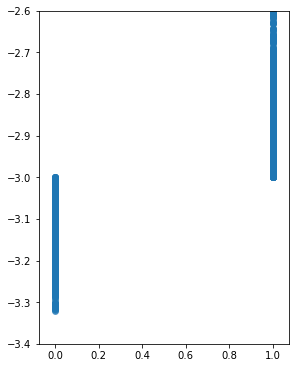

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
coord_fltele = coord[ft_pos_nodes - 1,dim-1]

fig = plt.figure(figsize=(4,5),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=1, left=0.05, right=0.48, wspace=0.05, figure=fig)
f2_ax2 = fig.add_subplot(spec2[0])
f2_ax2.scatter(p_sync,coord_fltele,  alpha=0.6,cmap='jet')
# f2_ax2.scatter(st_init[:,0]/st_init[:,1],coord_fltele,  alpha=0.6,cmap='jet')
# f2_ax2.set_xlim(e6, 5e6)
f2_ax2.set_ylim( -3.4, -2.6)

In [37]:
if poro: # with biot & perm
    np.savetxt(f,np.hstack((vecf,fc,fcd,dc,perm,st_init,xfnd,frc,coh,dcoh,biot,p_sync)),delimiter=' ',\
           fmt='%d '*2 + '%g '*9 + '%g '*3 + '%d ' + '%g '*3 + '%g '*3 + '%d '+ '%g '*3 + '%d')
# Auxiliary fault
if Xflt>1:
    np.savetxt(f,np.hstack((vecxf,stx_init)),delimiter=' ', fmt='%d '+'%g '*12)
    
#  point force/source
if nfnode>0:
    np.savetxt(f, fnode_bc, delimiter=' ',\
            fmt ='%d %1.2E %1.2E %1.2E %1.2E %g %g')
# Boundary traction
np.savetxt(f, np.column_stack((trac_el, trac_bc)), delimiter=' ',\
        fmt ='%d %d %1.2E %1.2E %1.2E %1.2E %g %g')
# Observation grid
np.savetxt(f,ogrid,delimiter=' ',fmt='%g '*3)
# Absorbing boundariesm
np.savetxt(f,abs_bc,delimiter=' ',fmt='%d %d %d')
f.close(); # necessary for successful save
print ('Defmod file '+fout+' created')

Defmod file Zeerijp_anhydrite.inp created


In [38]:
print (abs_bc[-1])
print (len(abs_bc))
print (len(trac_el))
print (np.column_stack((trac_el,trac_bc)).shape)
print (neq)
print (j*4)
print (nfnd)
print (np.hstack((vecf,fc,fcd,dc,st_init,xfnd,frc,coh,dcoh)).shape)

[2.60083e+05 3.00000e+00 3.00000e+00]
16106
7030
(7030, 8)
[7770.]
10360
2590
(2590, 23)


In [39]:
# import shutil
# shutil.copy(name_out, '/home/jingmingruan/Desktop/3Dexample/Zeerijp/')